In [1]:
# This shows some generalized mass sheet degeneracy results from the
# article "Lensing degeneracies and mass substructure"
# (https://ui.adsabs.harvard.edu/abs/2012MNRAS.425.1772L/abstract)
#
# We're going to start from a lens and two sources, and create a
# degenerate lens that corresponds to a rescaled version of the first
# source only, but leaves the second source unchanged.

%matplotlib inline

In [2]:
from grale.all_nb import *

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
# These are similar settings as used in the scaledegen.ipynb example
# For the first source, we'll also store the parameters for a scaled
# version (scaled towards the origin)

cosm = cosmology.Cosmology(0.7, 0.27, 0.0, 0.73)
cosmology.setDefaultCosmology(cosm)
D = cosm.getAngularDiameterDistance

zd = 0.5
zs1 = 1.2
zs2 = 1.8

src1Params = {
    "position": V(10, 5)*ANGLE_ARCSEC,
    "halfAxis": 1.1*ANGLE_ARCSEC,
    "eccentricity": 0.6,
    "angle": 30,
}

src1ParamsScaled = {
    "position": V(10, 5)*ANGLE_ARCSEC*0.75,
    "halfAxis": 1.1*ANGLE_ARCSEC*0.75,
    "eccentricity": 0.6,
    "angle": 30,
}

src2Params = {
    "position": V(2, -4.5)*ANGLE_ARCSEC,
    "halfAxis": 0.8*ANGLE_ARCSEC,
    "eccentricity": 0.4,
    "angle": 110,
}

Text(value='')

FloatProgress(value=0.0)

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

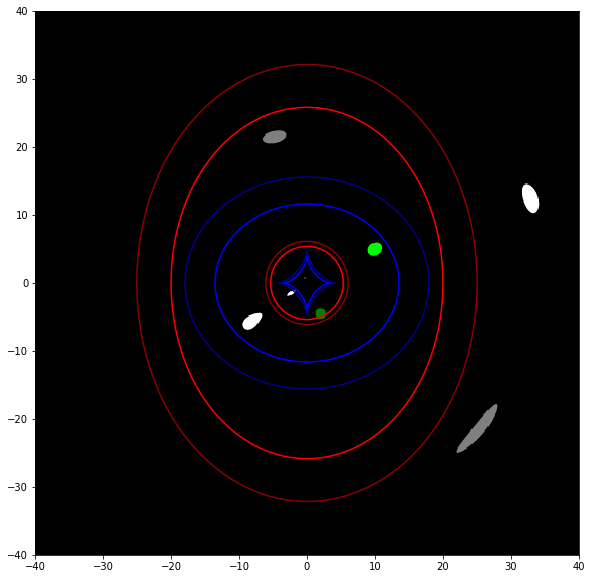

In [4]:
# Create the lens and plot the images

l = lenses.NSIELens(D(zd), { "velocityDispersion": 1300000, "ellipticity": 0.8, "coreRadius": 1.5*ANGLE_ARCSEC })
li = plotutil.LensInfo(l, size=80*ANGLE_ARCSEC, zd=zd, numxy=511)

plt.figure(figsize=(10, 10))
plotutil.plotImagePlane(li, [
    { "shape": images.EllipticalSource(**src1Params), "z": zs1 },
    { "shape": images.EllipticalSource(**src2Params), "z": zs2 } ],
    sourceRgb = [ (0,1,0), (0,0.5,0) ],
    imageRgb = [ (1,1,1), (0.5,0.5,0.5) ],
    caustColor = [ "blue", "darkblue" ],
    critColor = [ "red", "darkred" ]
)

In [5]:
# We're going to create ImagesData instances for these images, to do this, we'll
# first grab all non-zero pixels
li.setSourceRedshift(zs1)
ip = li.getImagePlane()
src1ImagePixels = ip.segment(ip.renderImages([images.EllipticalSource(**src1Params)]))

li.setSourceRedshift(zs2)
ip = li.getImagePlane()
src2ImagePixels = ip.segment(ip.renderImages([images.EllipticalSource(**src2Params)]))

Text(value='')

Text(value='')

In [6]:
# This helper function stores these pixel positions in an ImagesData instance. We'll
# also store the deflection angles at the pixel locations. While it is not used in
# this notebook, they are used in the creation of the degenerate lens (which is
# available as one of the examples in the 'inversion_examples' directory)
def pixelsToImagesData(pix):
    imgDat = images.ImagesData(len(pix), alpha=True)
    for i, img in zip(range(len(pix)), pix):
        for p in img:
            imgDat.addPoint(i, p, alpha=l.getAlphaVector(p)/ANGLE_ARCSEC)
    return imgDat

imgDat1 = pixelsToImagesData(src1ImagePixels)
imgDat2 = pixelsToImagesData(src2ImagePixels)

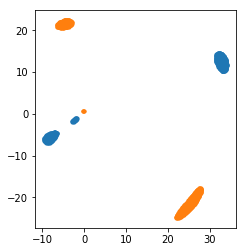

In [7]:
plotutil.plotImagesData([imgDat1, imgDat2])
plt.gca().set_aspect("equal")

In [8]:
# Now, we'll create a typical mass sheet degenerate lens, that works for
# the redshift of source 1
sheet = lenses.MassSheetLens(D(zd), { "Ds": D(zs1), "Dds": D(zd,zs1)})

lambd = 0.75
degen = lenses.CompositeLens(D(zd), [
    { "lens": l, "factor": lambd, "x": 0, "y": 0, "angle": 0 },
    { "lens": sheet, "factor": (1-lambd), "x": 0, "y": 0, "angle": 0}
])

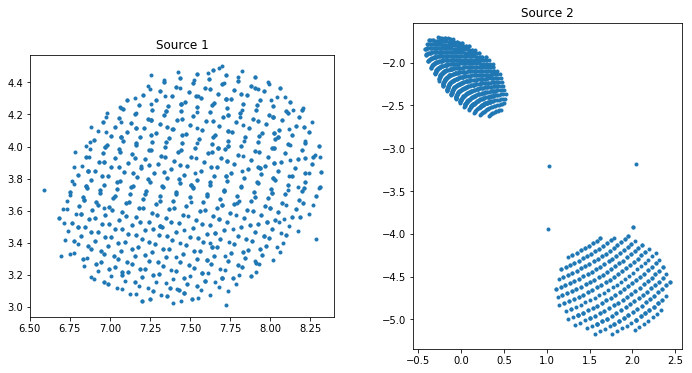

In [9]:
# When we project these images back onto their source planes with this
# degenerate lens, we see that indeed the back-projected images of source 1
# still overlap, but those for source 2, which has a different redshift
# do not
iws = inversion.InversionWorkSpace(zd, 80*ANGLE_ARCSEC)
iws.addImageDataToList(imgDat1, zs1, "extendedimages")
iws.addImageDataToList(imgDat2, zs2, "extendedimages")
bpImg = iws.backProject(degen)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plotutil.plotImagesData([bpImg[0]])
plt.gca().set_aspect("equal")
plt.title("Source 1")
plt.subplot(1,2,2)
plotutil.plotImagesData([bpImg[1]])
plt.gca().set_aspect("equal")
plt.title("Source 2");

In [10]:
# Here, we load the result from the 2012 article. As said before, the 'inversion_examples'
# directory contains a script to do something similar.
#
# In essence, we've started from the simple mass-sheet degenerate lens above, and, using
# monopole basis functions, have adjusted the deflection angles at the images of source 2
# to be the same again as in the original NSIE lens.
newdegen = lenses.GravitationalLens.load("scaledegen2012.lensdata")
ndli = plotutil.LensInfo(newdegen, size=80*ANGLE_ARCSEC, zd=zd)
plotutil.plotDensityInteractive(ndli)

Text(value='')

FloatProgress(value=0.0)

/home/jori/anaconda3-2019.03/envs/grale2/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

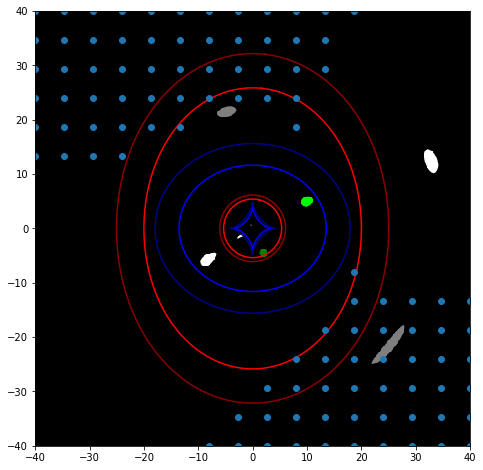

In [11]:
# This shows where the centers of the monopole basis functions were in this
# reconstruction, we'll set the same image planes as above as a background
# for reference.

# You can see that the monopole center positions are grid-based, but not all
# grid points are used:
#  - the regions of the basis functions should not overlap with the images of
#    source 1, we want to make sure that they are still back-projected onto
#    a rescaled version of that source (some extra space is taken into account)
#  - the monopole basis functions have zero total mass outside a certain radius
#    and will therefore not have any effect outside that radius. To have any
#    effect on the images of source 2, they should also overlap with those images

xs = []
ys = []
for p in newdegen.getLensParameters():
    if type(p["lens"]) == lenses.PolynomialMassProfileLens:
        xs.append(p["x"])
        ys.append(p["y"])

plt.figure(figsize=(8, 8))
plotutil.plotImagePlane(li, [
    { "shape": images.EllipticalSource(**src1Params), "z": zs1 },
    { "shape": images.EllipticalSource(**src2Params), "z": zs2 } ],
    sourceRgb = [ (0,1,0), (0,0.5,0) ],
    imageRgb = [ (1,1,1), (0.5,0.5,0.5) ],
    caustColor = [ "blue", "darkblue" ],
    critColor = [ "red", "darkred" ]
)

plt.plot(np.array(xs)/ANGLE_ARCSEC, np.array(ys)/ANGLE_ARCSEC, "o")
plt.gca().set_aspect("equal")

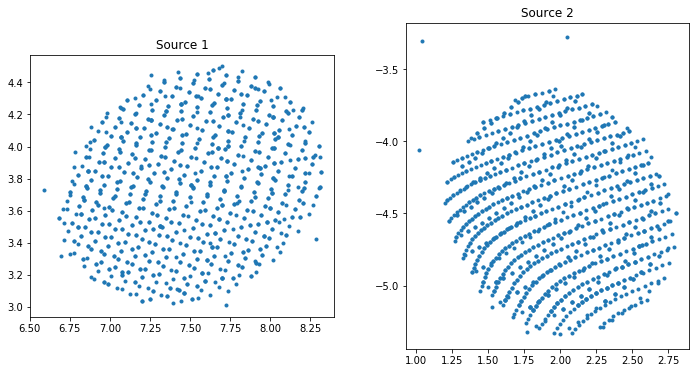

In [12]:
# Let's backproject the images with this degenerate lens. As you can see, the
# images of source 1 are not affected, they still overlap well. The images of
# source 2 now overlap much better however.
bpImg = iws.backProject(newdegen)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plotutil.plotImagesData([bpImg[0]])
plt.gca().set_aspect("equal")
plt.title("Source 1")
plt.subplot(1,2,2)
plotutil.plotImagesData([bpImg[1]])
plt.gca().set_aspect("equal")
plt.title("Source 2");

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

FloatProgress(value=0.0)

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

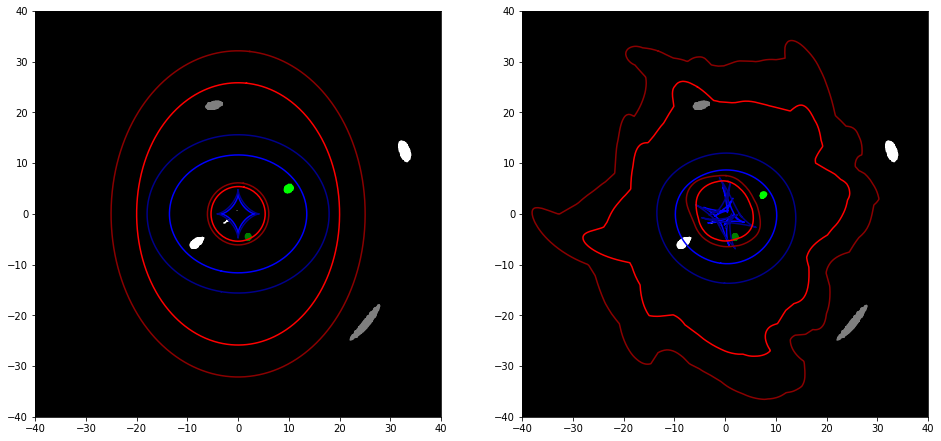

In [13]:
# Let's plot the original image plane, as well as the image plane for this
# degenerate lens, where a scaled version of the first source is used, but
# the same second source is used.
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plotutil.plotImagePlane(li, [
    { "shape": images.EllipticalSource(**src1Params), "z": zs1 },
    { "shape": images.EllipticalSource(**src2Params), "z": zs2 } ],
    sourceRgb = [ (0,1,0), (0,0.5,0) ],
    imageRgb = [ (1,1,1), (0.5,0.5,0.5) ],
    caustColor = [ "blue", "darkblue" ],
    critColor = [ "red", "darkred" ]
)
plt.subplot(1,2,2)
plotutil.plotImagePlane(ndli, [
    { "shape": images.EllipticalSource(**src1ParamsScaled), "z": zs1 },
    { "shape": images.EllipticalSource(**src2Params), "z": zs2 } ],
    sourceRgb = [ (0,1,0), (0,0.5,0) ],
    imageRgb = [ (1,1,1), (0.5,0.5,0.5) ],
    caustColor = [ "blue", "darkblue" ],
    critColor = [ "red", "darkred" ]
);